In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from time import time
import dpp_sampler as sampler
import numpy as np
import os
import copy

In [2]:
# Hyper Parameters 
input_size = 2
num_classes = 2
num_epochs = 3000
batch_size = 150
learning_rate = 0.1
max_sample_count = 1000
sub_sample_count = 150
active_dpp_batch_size = 40

In [3]:
data = torch.Tensor(np.load('data_synthetic/data3.npy'))
labels = torch.LongTensor(np.load('data_synthetic/labels3.npy'))
test_data = torch.Tensor(np.load('data_synthetic/data3_test.npy'))
test_labels = torch.LongTensor(np.load('data_synthetic/labels3_test.npy'))

In [4]:
# DNN Model
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.Sigmoid(),
            nn.Linear(4, num_classes)
        )
    
    def forward(self, x):
        out = self.classifier(x)
        return nn.functional.softmax(out, dim=1)

In [5]:
def train_and_test(train_imgs, train_lbls, test_imgs, test_lbls, verbose=True, batch_size=batch_size):
    model = DNN(input_size, num_classes)
    
    # Loss and train_labelsOptimizer
    # Softmax is internally computed.
    # Set parameters to be updated.
    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0) # weigth decay about 1e-3, 1e-4 is ok  

    # Training the Model
    for epoch in range(num_epochs):
        shuffle_ids = torch.randperm(train_lbls.shape[0])
        train_imgs = train_imgs[shuffle_ids]
        train_lbls = train_lbls[shuffle_ids]

        for i in range(train_lbls.shape[0] // batch_size):
            images = train_imgs[i*batch_size : (i+1)*batch_size]
            labels = train_lbls[i*batch_size : (i+1)*batch_size]

            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if verbose and (i+1) % (train_lbls.shape[0] // batch_size) == 0:
                print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                       % (epoch+1, num_epochs, i+1, len(train_lbls)//batch_size, loss.item()))


    # Calculate training accuracy
    images = train_imgs[:]
    labels = train_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()

    print('Accuracy of the model on the train images: %d %%' % (100 * correct / total))



    # Test the Model
    images = test_imgs[:]
    labels = test_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()

    print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    return model, float(correct)/total

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def draw(points):
    #plt.figure(figsize=(4,4))
    plt.scatter([x for x, y in points], [y for x, y in points])
    plt.xlim(-3*np.pi, 3*np.pi)
    plt.ylim(-3*np.pi, 3*np.pi)
    plt.gca().set_aspect('equal')
    plt.pause(0.05)
    #plt.savefig('fig/uniform', bbox_inches='tight')

In [ ]:
# Full model
model, test_acc = train_and_test(data, labels, test_data, test_labels, verbose=False)

Accuracy of the model on the train images: 78 %
Accuracy of the model on the test images: 71 %


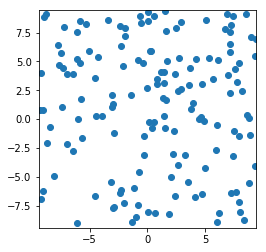

In [15]:
# Random subset model
sub_ids = torch.randperm(labels.shape[0])
train_ids = sub_ids[:sub_sample_count]
model, test_acc = train_and_test(data[train_ids], labels[train_ids], test_data, test_labels, verbose=False)
draw(data[train_ids].detach().numpy())

Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 84 %


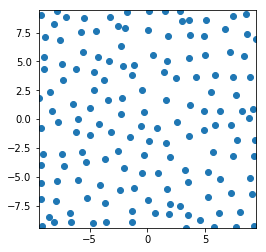

In [16]:
# Passive DPP subset model
train_ids = sampler.sample_ids_mc(data.numpy(), np.ones(labels.shape[0]), k=sub_sample_count, alpha=4., gamma=0.)

mask = np.full(labels.shape[0], True, dtype=bool)
mask[train_ids] = False

model, test_acc = train_and_test(data[train_ids], labels[train_ids], test_data, test_labels, verbose=False)
draw(data[train_ids].detach().numpy())

Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 59 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 66 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 63 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 57 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 61 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 60 %
Accuracy of the model on the train images: 100 %
Accuracy of the model on the test images: 68 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 57 %
Accuracy of the model on the train images: 100 %


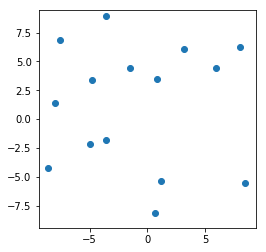

Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 78 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 76 %
Accuracy of the model on the test images: 65 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 66 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 70 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 79 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 59 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 79 %
Accuracy of the model on the train images: 76 %
Ac

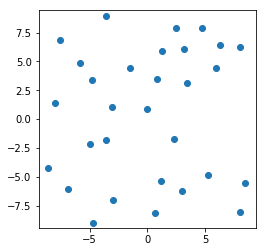

Accuracy of the model on the train images: 95 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 97 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 91 %
Accuracy of the model on the test images: 78 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 97 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 97 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 97 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 95 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 97 %
Ac

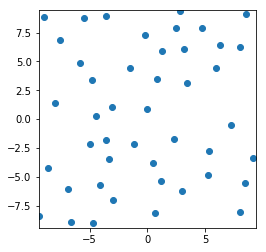

Accuracy of the model on the train images: 95 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 75 %
Accuracy of the model on the test images: 69 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 76 %
Accuracy of the model on the test images: 72 %
Accuracy of the model on the train images: 76 %
Accuracy of the model on the test images: 70 %
Accuracy of the model on the train images: 96 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 95 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 76 %
Ac

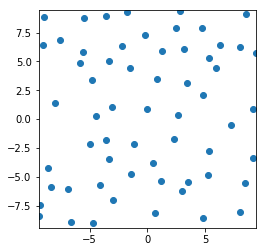

Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 81 %
Accuracy of the model on the test images: 79 %
Accuracy of the model on the train images: 92 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Ac

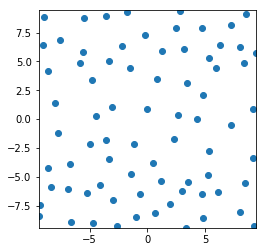

Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 75 %
Accuracy of the model on the train images: 92 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 92 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 73 %
Accuracy of the model on the test images: 71 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 91 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 82 %
Ac

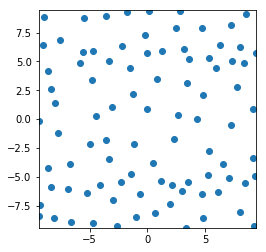

Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 79 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 92 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 92 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 77 %
Accuracy of the model on the test images: 73 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 93 %
Ac

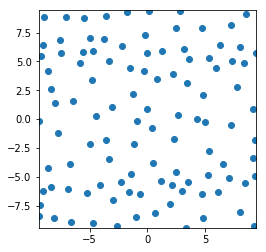

Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 81 %
Accuracy of the model on the test images: 76 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 82 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 69 %
Accuracy of the model on the test images: 71 %
Accuracy of the model on the train images: 61 %
Ac

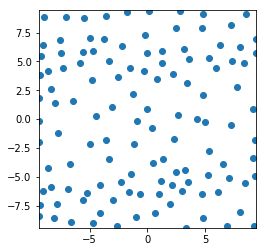

Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 87 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 91 %
Accuracy of the model on the test images: 87 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 91 %
Ac

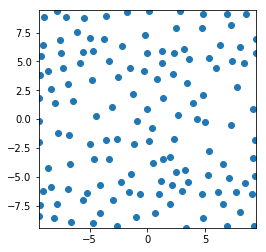

Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 87 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 87 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 68 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 87 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 86 %
Ac

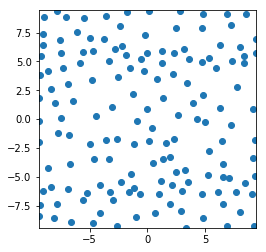

Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 81 %


In [7]:
# Active DPP subset model (new sampler w/ conditioning)
scores = np.ones(labels.shape[0])
train_ids = []

batches = [15]*10

for i in range(len(batches)):
    k = int(np.ceil(2.0*batches[i]/3))
    #k = batches[i]
    new_train_ids = sampler.cond_sample_ids_mc(data.numpy(), scores, cond_ids=train_ids, k=k, alpha=4., gamma=5.)
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)
    new_train_ids = sampler.cond_sample_ids_mc(data.numpy(), scores, cond_ids=train_ids, k=batches[i]-k, alpha=4., gamma=0.)
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)

    mask = np.full(labels.shape[0], True, dtype=bool)
    mask[train_ids] = False
    remaining_ids = np.arange(labels.shape[0])[mask]


    out = np.zeros((20,data.shape[0],num_classes))
    models = []
    for j in range(20):
        m, test_acc = train_and_test(data[train_ids], labels[train_ids], data[remaining_ids], labels[remaining_ids], verbose=False, batch_size=len(train_ids))
        models.append(m)
        out[j,:,:] = models[j](data).detach().numpy()

    out = np.mean(out, axis=0)
    scores = np.sum(-out*np.log(out),axis=1)
    scores[scores!=scores] = 0 # because 0*log(0)=0
    scores = scores + 1e-8 # just to make sure condition is not zero-probability

    draw(data[train_ids].detach().numpy())
#import pdb; pdb.set_trace()
model, test_acc = train_and_test(data[train_ids], labels[train_ids], test_data, test_labels, verbose=False, batch_size=len(train_ids))

In [ ]:
draw(data[train_ids].detach().numpy())
plt.savefig('fig/passive', bbox_inches='tight')